# **Data loading**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to your file on Google Drive
file_path = "/content/drive/My Drive/depression_dataset_reddit_cleaned.csv"

# Copy the file to Colab under the /content directory
!cp "{file_path}" /content

# Load the CSV file into a DataFrame
import pandas as pd
df = pd.read_csv("/content/depression_dataset_reddit_cleaned.csv")

# Display the DataFrame
print(df.head())

Mounted at /content/drive
                                          clean_text  is_depression
0  we understand that most people who reply immed...              1
1  welcome to r depression s check in post a plac...              1
2  anyone else instead of sleeping more when depr...              1
3  i ve kind of stuffed around a lot in my life d...              1
4  sleep is my greatest and most comforting escap...              1




---



# **LSTM**

Pretrained

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7471 - loss: 0.5109 - val_accuracy: 0.9858 - val_loss: 0.2265 - learning_rate: 0.0010
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9672 - loss: 0.1156 - val_accuracy: 0.9884 - val_loss: 0.0904 - learning_rate: 0.0010
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9749 - loss: 0.0762 - val_accuracy: 0.9722 - val_loss: 0.1166 - learning_rate: 0.0010
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9800 - loss: 0.0591 - val_accuracy: 0.9890 - val_loss: 0.0550 - learning_rate: 0.0010
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9868 - loss: 0.0391 - val_accuracy: 0.9683 - val_loss: 0.1140 - learning_rate: 0.0010
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9879 - loss: 0.0387 - val_accuracy: 0.9748 - val_loss: 0.0927 - learning_rate: 0.0010
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9886 - loss: 0.0365 - val_accuracy: 0.98

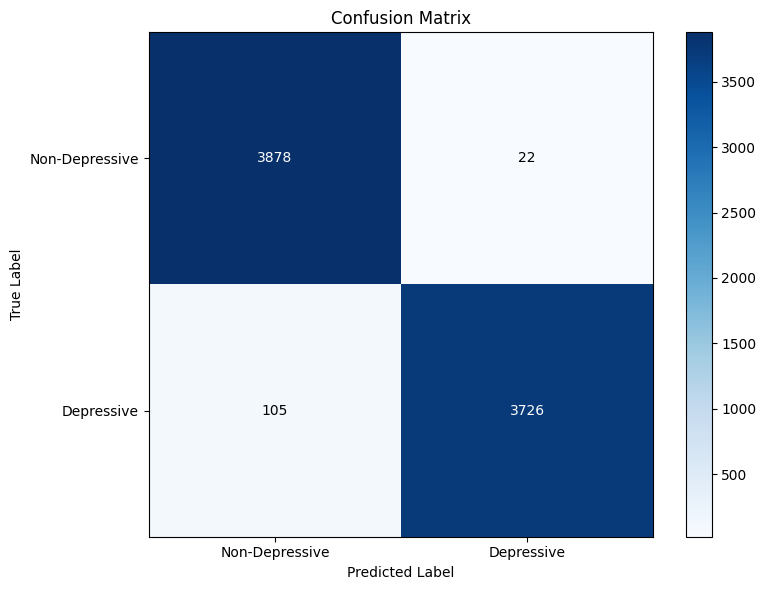

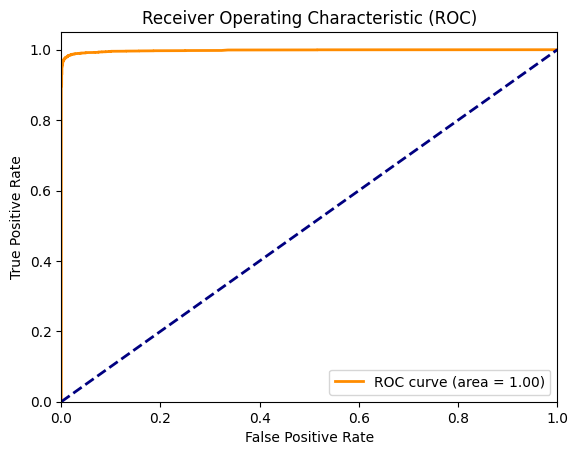

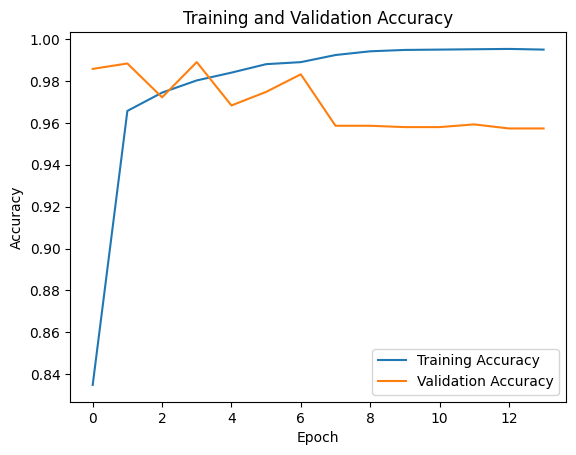

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalMaxPool1D
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv("/content/depression_dataset_reddit_cleaned.csv")

# Drop rows with missing or NaN labels
data = data.dropna(subset=['is_depression'])

# Drop rows with missing or NaN text
data = data.dropna(subset=['clean_text'])

texts = data["clean_text"].astype(str).tolist()
labels = data["is_depression"].values

# Tokenize the texts and create sequences
max_sequence_length = 100  # Adjust based on your data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts) # what type of encoding is used ?
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post', maxlen=max_sequence_length)

# Define the model
model = Sequential([
    Embedding(input_dim=1000, output_dim=64, input_length=max_sequence_length),
    Bidirectional(LSTM(32, return_sequences=True)),
    GlobalMaxPool1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback with increased patience
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define ReduceLROnPlateau callback for reducing learning rate when the validation loss stops improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with 30 epochs and callbacks
batch_size = 64  # Experiment with different batch sizes
history = model.fit(padded_sequences, labels, epochs=30, batch_size=batch_size, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

# Now let's evaluate the model
y_true = labels
y_pred = model.predict(padded_sequences)

# Convert predictions to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Calculate AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Calculate F1-score
f1 = classification_report(y_true, y_pred_binary, target_names=["Non-Depressive", "Depressive"])

# Print evaluation metrics
print("Confusion Matrix:")
print(cm)
print("\nAUC-ROC Curve:")
print(f"AUC = {roc_auc:.4f}")
print("\nF1-Score:")
print(f1)

# Save the confusion matrix as an image with annotations
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add annotations to the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

# Add labels and titles
plt.xticks([0, 1], ["Non-Depressive", "Depressive"])
plt.yticks([0, 1], ["Non-Depressive", "Depressive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Save the AUC-ROC curve as an image
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')

# Optionally, you can also save the training history plot
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_history.png')


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7274 - loss: 0.5030 - val_accuracy: 0.9916 - val_loss: 0.1511 - learning_rate: 0.0010
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9689 - loss: 0.1017 - val_accuracy: 0.9670 - val_loss: 0.1666 - learning_rate: 0.0010
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9771 - loss: 0.0714 - val_accuracy: 0.9787 - val_loss: 0.0879 - learning_rate: 0.0010
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9794 - loss: 0.0615 - val_accuracy: 0.9554 - val_loss: 0.1761 - learning_rate: 0.0010
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9878 - loss: 0.0459 - val_accuracy: 0.9573 - val_loss: 0.1652 - learning_rate: 0.0010
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9897 - loss: 0.0374 - val_accuracy: 0.9677 - val_loss: 0.1463 - learning_rate: 0.0010
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9916 - loss: 0.0370 - val_accuracy: 0.95

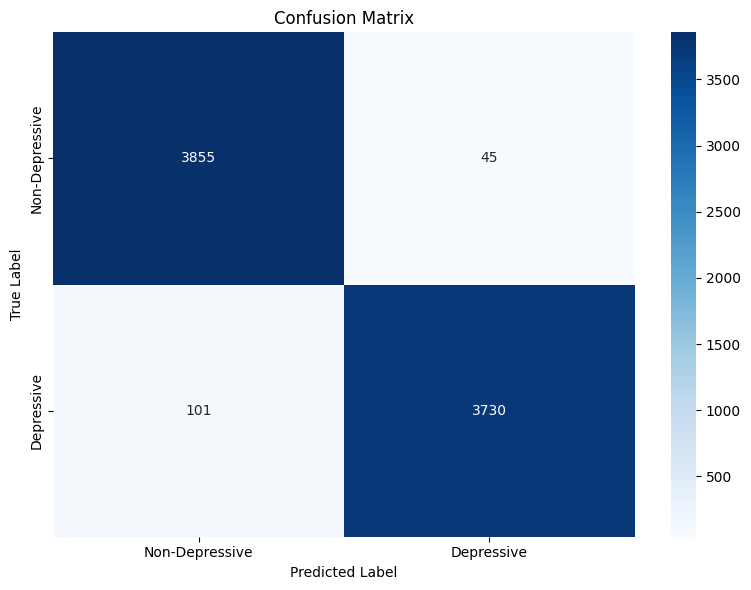

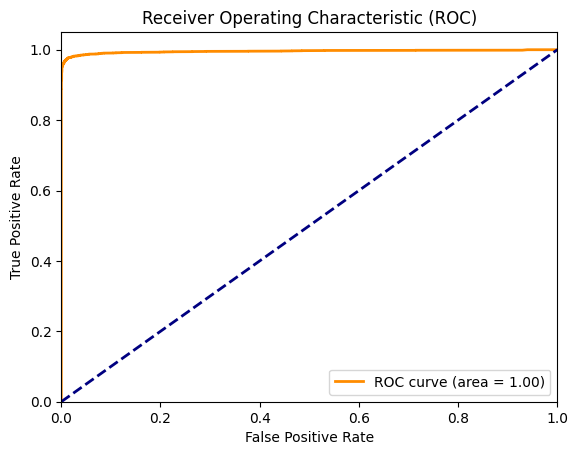

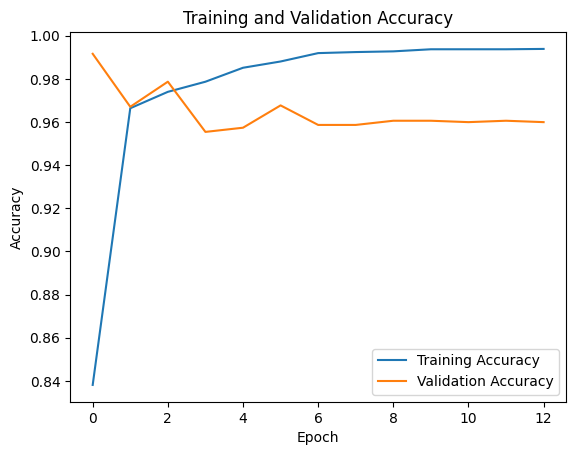

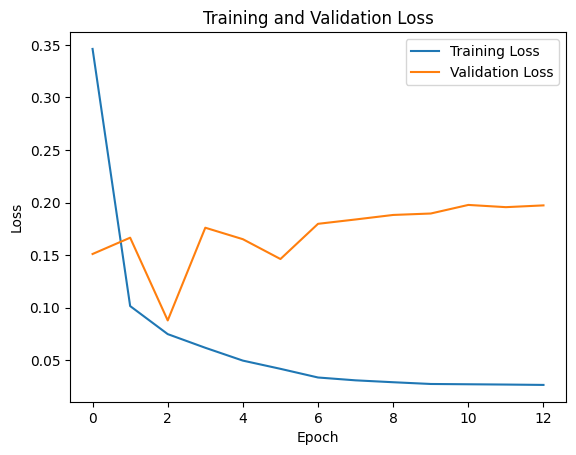

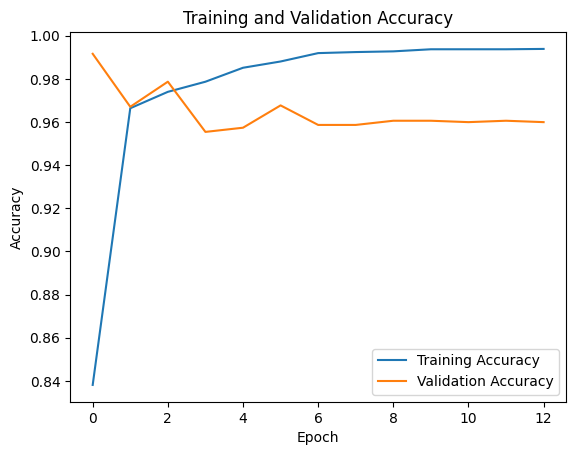

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalMaxPool1D
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from CSV file
data = pd.read_csv("/content/depression_dataset_reddit_cleaned.csv")

# Drop rows with missing or NaN labels
data = data.dropna(subset=['is_depression'])

# Drop rows with missing or NaN text
data = data.dropna(subset=['clean_text'])

texts = data["clean_text"].astype(str).tolist()
labels = data["is_depression"].values

# Tokenize the texts and create sequences
max_sequence_length = 100  # Adjust based on your data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post', maxlen=max_sequence_length)

# Define the model
model = Sequential([
    Embedding(input_dim=1000, output_dim=64, input_length=max_sequence_length),
    Bidirectional(LSTM(32, return_sequences=True)),
    GlobalMaxPool1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback with increased patience
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define ReduceLROnPlateau callback for reducing learning rate when the validation loss stops improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with 30 epochs and callbacks
batch_size = 64  # Experiment with different batch sizes
history = model.fit(padded_sequences, labels, epochs=30, batch_size=batch_size, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

# Visualizing Hyperparameters
hyperparameters = {
    'Max Sequence Length': max_sequence_length,
    'Embedding Output Dim': 64,
    'LSTM Units': 32,
    'Batch Size': batch_size,
    'Epochs': 30,
    'Optimizer': 'Adam',
    'Loss Function': 'Binary Crossentropy'
}

# Convert the hyperparameters dictionary into a DataFrame for display
hyperparameter_df = pd.DataFrame(list(hyperparameters.items()), columns=['Hyperparameter', 'Value'])

# Display hyperparameters table
print("\nHyperparameters:")
print(hyperparameter_df)

# Now let's evaluate the model
y_true = labels
y_pred = model.predict(padded_sequences)

# Convert predictions to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Calculate AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Calculate F1-score
f1 = classification_report(y_true, y_pred_binary, target_names=["Non-Depressive", "Depressive"])

# Print evaluation metrics
print("\nConfusion Matrix:")
print(cm)
print("\nAUC-ROC Curve:")
print(f"AUC = {roc_auc:.4f}")
print("\nF1-Score:")
print(f1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Depressive", "Depressive"], yticklabels=["Non-Depressive", "Depressive"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Plot AUC-ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')

# Plot Training and Validation Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_accuracy.png')

# Plot Training and Validation Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_loss.png')

# Optionally, you can also save the training history plot
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_history.png')


Word2Vec

[==================================================] 100.0% 1662.8/1662.8MB downloaded


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 271ms/step - accuracy: 0.7368 - loss: 0.4497 - val_accuracy: 0.9910 - val_loss: 0.1449 - learning_rate: 0.0010
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 306ms/step - accuracy: 0.9600 - loss: 0.1247 - val_accuracy: 0.9780 - val_loss: 0.1247 - learning_rate: 0.0010
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 439ms/step - accuracy: 0.9627 - loss: 0.1067 - val_accuracy: 0.9922 - val_loss: 0.0623 - learning_rate: 0.0010
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 29s 296ms/step - accuracy: 0.9726 - loss: 0.0870 - val_accuracy: 0.9735 - val_loss: 0.1132 - learning_rate: 0.0010
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 254ms/step - accuracy: 0.9745 - loss: 0.0768 - val_accuracy: 0.9838 - val_loss: 0.0740 - learning_rate: 0.0010
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 286ms/step - accuracy: 0.9719 - loss: 0.0759 - val_accuracy: 0.9845 - val_loss: 0.0658 - learning_rate: 0.0010
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 261ms/step - accuracy: 0.9808 - loss: 0.

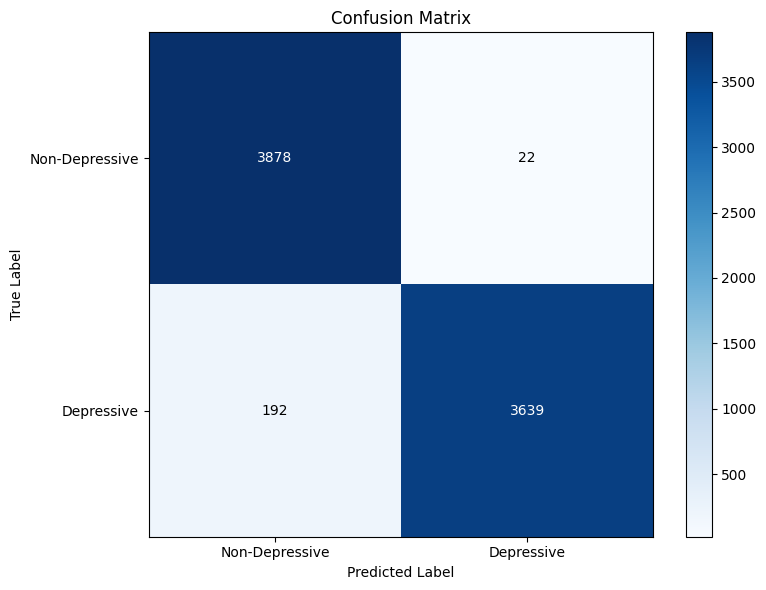

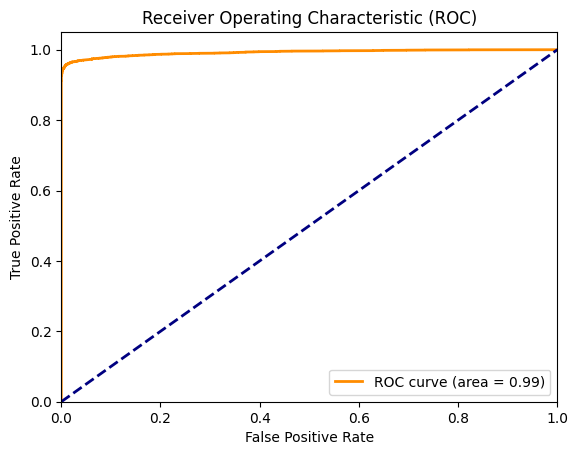

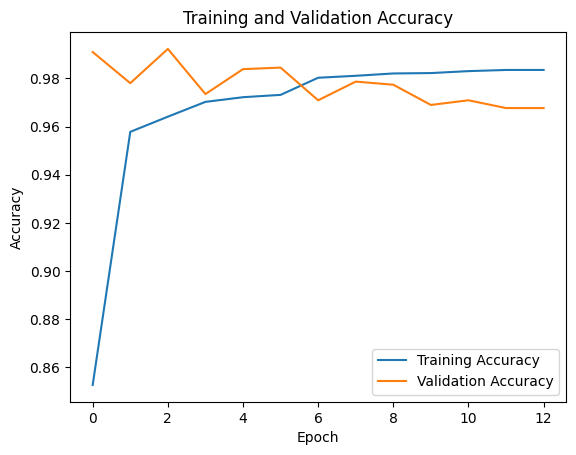

In [ ]:
import gensim
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Dense
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import gensim.downloader as api

# Step 1: Load pre-trained Word2Vec model from Gensim's API
word2vec_model = api.load("word2vec-google-news-300")  # This loads the Google News Word2Vec model

# Step 2: Load data from CSV file
data = pd.read_csv("/content/depression_dataset_reddit_cleaned.csv")

# Drop rows with missing or NaN labels
data = data.dropna(subset=['is_depression'])

# Drop rows with missing or NaN text
data = data.dropna(subset=['clean_text'])

texts = data["clean_text"].astype(str).tolist()
labels = data["is_depression"].values

# Step 3: Tokenize the texts and create sequences
max_sequence_length = 100  # Adjust based on your data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)  # Tokenizing the text

# Step 4: Pad the sequences
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post', maxlen=max_sequence_length)

# Step 5: Prepare the embedding matrix from the Word2Vec model
embedding_dim = 300  # Google News Word2Vec embedding dimension is 300
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

# Populate the embedding matrix with the word embeddings from Word2Vec model
for word, index in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[index] = word2vec_model[word]

# Step 6: Define the LSTM model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1,
              output_dim=embedding_dim,
              weights=[embedding_matrix],  # Use the embedding matrix
              input_length=max_sequence_length,
              trainable=False),  # Set trainable=False so that embeddings are not updated during training
    Bidirectional(LSTM(32, return_sequences=True)),
    GlobalMaxPool1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Step 7: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback with increased patience
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define ReduceLROnPlateau callback for reducing learning rate when the validation loss stops improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Step 8: Train the model
batch_size = 64  # Experiment with different batch sizes
history = model.fit(padded_sequences, labels, epochs=30, batch_size=batch_size, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

# Step 9: Evaluate the model
y_true = labels
y_pred = model.predict(padded_sequences)

# Convert predictions to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Calculate AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Calculate F1-score
f1 = classification_report(y_true, y_pred_binary, target_names=["Non-Depressive", "Depressive"])

# Print evaluation metrics
print("Confusion Matrix:")
print(cm)
print("\nAUC-ROC Curve:")
print(f"AUC = {roc_auc:.4f}")
print("\nF1-Score:")
print(f1)

# Step 10: Save the confusion matrix as an image with annotations
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add annotations to the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

# Add labels and titles
plt.xticks([0, 1], ["Non-Depressive", "Depressive"])
plt.yticks([0, 1], ["Non-Depressive", "Depressive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Step 11: Save the AUC-ROC curve as an image
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')

# Optionally, you can also save the training history plot
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_history.png')


Streaming output truncated to the last 5000 lines.
 -0.04907227  0.02502441 -0.02075195 -0.01501465  0.10498047  0.03015137
  0.01544189 -0.07910156  0.01312256  0.05664062  0.09863281 -0.05004883
  0.01696777 -0.01556396 -0.04882812 -0.01080322 -0.04296875 -0.09814453
 -0.0546875   0.05078125  0.04907227 -0.08203125 -0.03491211 -0.0065918
 -0.00015354  0.01092529  0.00360107  0.0201416  -0.01904297 -0.01623535
  0.07617188  0.06933594  0.04052734 -0.04833984 -0.02844238 -0.08154297
 -0.04467773  0.0213623  -0.06982422  0.06738281  0.06494141  0.0456543
  0.00830078  0.02819824  0.02575684  0.04077148  0.04370117 -0.05419922
  0.00202942  0.0100708  -0.05395508  0.01556396 -0.01904297 -0.10449219
 -0.09716797  0.04394531  0.0098877   0.09960938  0.06689453 -0.01879883
  0.00708008 -0.02282715 -0.09423828  0.0546875   0.03125    -0.03295898
 -0.00601196  0.02307129 -0.06640625  0.01043701 -0.01977539  0.00891113
 -0.01104736  0.02075195  0.01556396  0.0625     -0.00897217 -0.02246094
 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6915 - loss: 0.5203 - val_accuracy: 0.9638 - val_loss: 0.2713 - learning_rate: 0.0010
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9575 - loss: 0.1474 - val_accuracy: 0.9890 - val_loss: 0.0995 - learning_rate: 0.0010
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9624 - loss: 0.1124 - val_accuracy: 0.9935 - val_loss: 0.0636 - learning_rate: 0.0010
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9661 - loss: 0.0933 - val_accuracy: 0.9619 - val_loss: 0.1274 - learning_rate: 0.0010
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9697 - loss: 0.0875 - val_accuracy: 0.9871 - val_loss: 0.0785 - learning_rate: 0.0010
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9742 - loss: 0.0760 - val_accuracy: 0.9651 - val_loss: 0.1264 - learning_rate: 0.0010
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9768 - loss: 0.0686 - val_acc

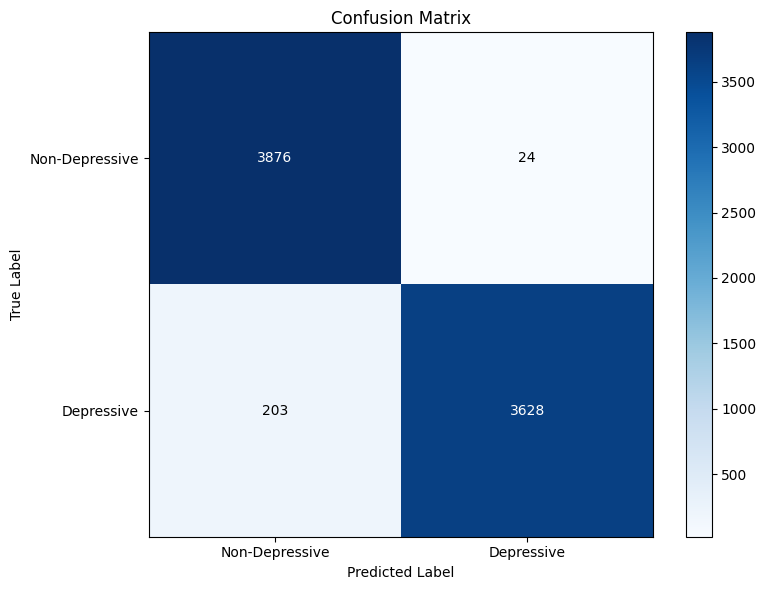

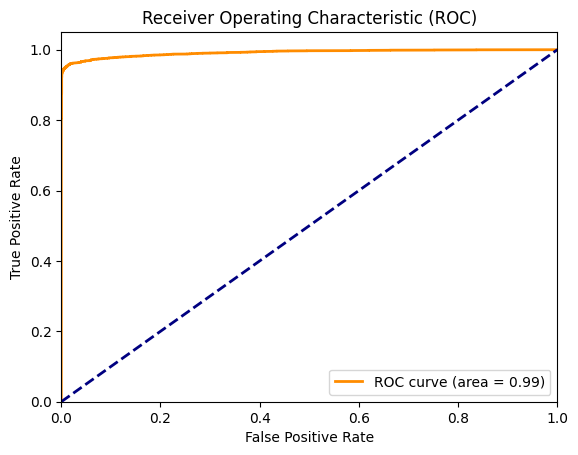

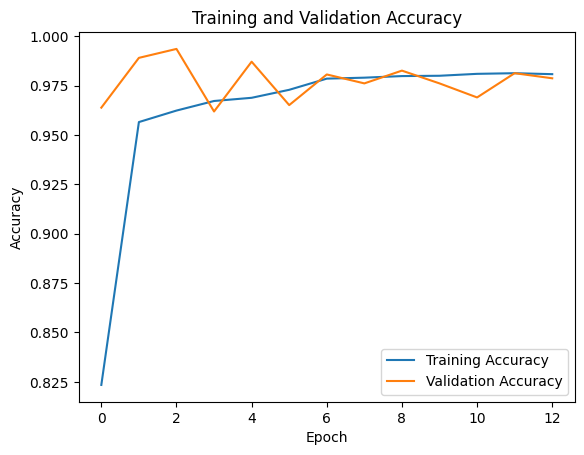

In [ ]:
import gensim
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Dense
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import gensim.downloader as api

# Step 1: Load pre-trained Word2Vec model from Gensim's API
word2vec_model = api.load("word2vec-google-news-300")  # Loads the Google News Word2Vec model

# Step 2: Load data from CSV file
data = pd.read_csv("/content/depression_dataset_reddit_cleaned.csv")

# Drop rows with missing or NaN labels
data = data.dropna(subset=['is_depression'])

# Drop rows with missing or NaN text
data = data.dropna(subset=['clean_text'])

texts = data["clean_text"].astype(str).tolist()
labels = data["is_depression"].values

# Step 3: Tokenize the texts and create sequences
max_sequence_length = 100  # Adjust based on your data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)  # Tokenizing the text

# Step 4: Pad the sequences
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post', maxlen=max_sequence_length)

# Step 5: Prepare the embedding matrix from the Word2Vec model
embedding_dim = 300  # Google News Word2Vec embedding dimension is 300
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

print("\nPrinting Word Vectors:")

# Populate the embedding matrix with the word embeddings from Word2Vec model
for word, index in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[index] = word2vec_model[word]
        print(f"Word: {word}")
        print(f"Vector: {word2vec_model[word]}\n")
    else:
        print(f"Word: {word} - No vector found in Word2Vec model.\n")

# Optional: Save vectors to a file
with open("word_vectors.txt", "w") as file:
    for word, index in tokenizer.word_index.items():
        if word in word2vec_model:
            file.write(f"Word: {word}\n")
            file.write(f"Vector: {word2vec_model[word].tolist()}\n\n")

# Step 6: Define the LSTM model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1,
              output_dim=embedding_dim,
              weights=[embedding_matrix],  # Use the embedding matrix
              input_length=max_sequence_length,
              trainable=False),  # Set trainable=False so that embeddings are not updated during training
    Bidirectional(LSTM(32, return_sequences=True)),
    GlobalMaxPool1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Step 7: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback with increased patience
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define ReduceLROnPlateau callback for reducing learning rate when the validation loss stops improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Step 8: Train the model
batch_size = 64  # Experiment with different batch sizes
history = model.fit(padded_sequences, labels, epochs=30, batch_size=batch_size, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

# Step 9: Evaluate the model
y_true = labels
y_pred = model.predict(padded_sequences)

# Convert predictions to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Calculate AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Calculate F1-score
f1 = classification_report(y_true, y_pred_binary, target_names=["Non-Depressive", "Depressive"])

# Print evaluation metrics
print("Confusion Matrix:")
print(cm)
print("\nAUC-ROC Curve:")
print(f"AUC = {roc_auc:.4f}")
print("\nF1-Score:")
print(f1)

# Step 10: Save the confusion matrix as an image with annotations
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add annotations to the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

# Add labels and titles
plt.xticks([0, 1], ["Non-Depressive", "Depressive"])
plt.yticks([0, 1], ["Non-Depressive", "Depressive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Step 11: Save the AUC-ROC curve as an image
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')

# Optionally, you can also save the training history plot
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_history.png')


Test Data (20%) - LSTM

Training samples: 6184
Evaluation samples: 1547


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Accuracy across runs: [np.float64(0.9618616677440207), np.float64(0.97349709114415), np.float64(0.967032967032967), np.float64(0.97349709114415), np.float64(0.9722042663219134)]
Mean Accuracy = 0.9696, Std = 0.0046


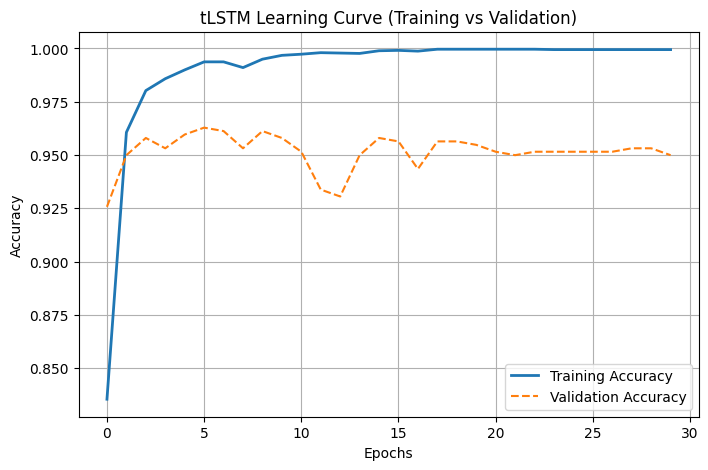

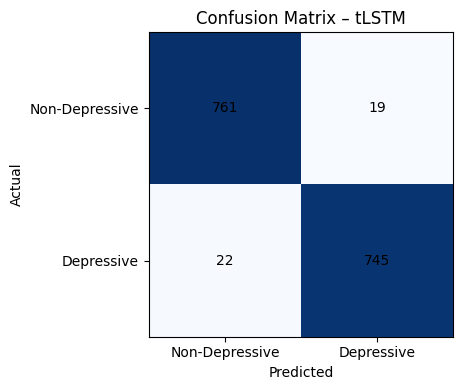

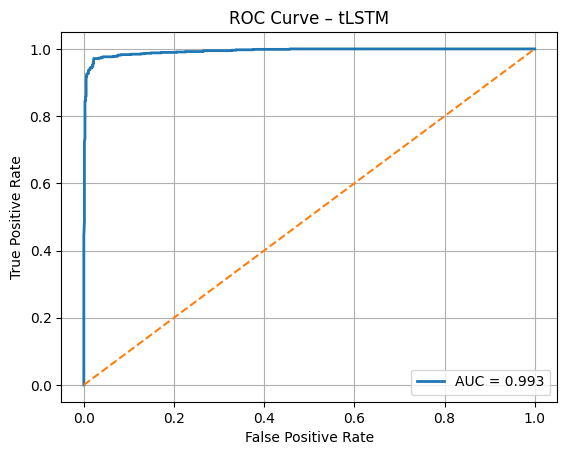

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# ------------------------
# Load Dataset
# ------------------------
df = pd.read_csv("/content/depression_dataset_reddit_cleaned.csv").dropna(subset=["clean_text", "is_depression"])
texts = df["clean_text"].astype(str).tolist()
labels = df["is_depression"].astype(int).values

# ------------------------
# Train–Test Split (80/20, stratified)
# ------------------------
RANDOM_STATE_MASTER = 42
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.20, stratify=labels, random_state=RANDOM_STATE_MASTER
)
print("Training samples:", len(y_train))
print("Evaluation samples:", len(y_test))  # Should be 1,547

# ------------------------
# Global Hyperparameters
# ------------------------
max_words = 10000
max_len = 100
batch_size = 64
epochs = 30

# ------------------------
# Repeatable LSTM Runner
# ------------------------
def run_lstm(seed):
    tf.keras.utils.set_random_seed(seed)

    # Tokenizer (trained only on training data)
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="<oov>")
    tokenizer.fit_on_texts(X_train)

    X_tr = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len, padding='post')
    X_te = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding='post')

    # LSTM Model (exactly matching paper)
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.GlobalMaxPool1D(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_tr, y_train,
        validation_split=0.10,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    # Evaluate
    y_proba = model.predict(X_te, verbose=0).ravel()
    y_pred = (y_proba > 0.5).astype(int)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_val = auc(fpr, tpr)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["Non-Depressive", "Depressive"], zero_division=0)

    return {
        "acc": np.mean(y_pred == y_test),
        "auc": auc_val,
        "cm": cm,
        "report": report,
        "fpr": fpr,
        "tpr": tpr,
        "history": history.history
    }

# ------------------------
# Run Stability Test: 5 Runs
# ------------------------
seeds = [11, 22, 33, 44, 55]
results = [run_lstm(s) for s in seeds]
accs = [r["acc"] for r in results]

print(f"\nAccuracy across runs: {accs}")
print(f"Mean Accuracy = {np.mean(accs):.4f}, Std = {np.std(accs):.4f}")

best_run = results[np.argmax(accs)]

# ------------------------
# Figures
# ------------------------

# Learning Curves (accuracy + loss together)
plt.figure(figsize=(8,5))
plt.plot(best_run["history"]["accuracy"], label="Training Accuracy", linewidth=2)
plt.plot(best_run["history"]["val_accuracy"], label="Validation Accuracy", linestyle='--')
plt.title("tLSTM Learning Curve (Training vs Validation)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig("tlstm_learning_curve.png", dpi=300)

# Confusion Matrix
plt.figure(figsize=(5,4))
plt.imshow(best_run["cm"], cmap="Blues")
for i in range(2):
    for j in range(2):
        plt.text(j, i, best_run["cm"][i,j], ha="center", va="center")
plt.xticks([0,1], ["Non-Depressive", "Depressive"])
plt.yticks([0,1], ["Non-Depressive", "Depressive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – tLSTM")
plt.tight_layout()
plt.savefig("tlstm_confusion_matrix.png", dpi=300)

# ROC Curve
plt.figure()
plt.plot(best_run["fpr"], best_run["tpr"], linewidth=2, label=f"AUC = {best_run['auc']:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – tLSTM")
plt.legend()
plt.grid()
plt.savefig("tlstm_roc_curve.png", dpi=300)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 39.3 MB/s eta 0:00:00
Loading Word2Vec model (1.6GB)...
[==================================================] 100.0% 1662.8/1662.8MB downloaded


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_10         │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

Epoch 1/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7053 - loss: 0.5093 - val_accuracy: 0.9208 - val_loss: 0.2116
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9456 - loss: 0.1606 - val_accuracy: 0.9596 - val_loss: 0.1183
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9661 - loss: 0.1146 - val_accuracy: 0.9661 - val_loss: 0.1065
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9710 - loss: 0.0927 - val_accuracy: 0.9645 - val_loss: 0.1003
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9726 - loss: 0.0858 - val_accuracy: 0.9709 - val_loss: 0.0929
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9755 - loss: 0.0753 - val_accuracy: 0.9661 - val_loss: 0.0912
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9764 - loss: 0.0702 - val_accuracy: 0.9677 - val_loss: 0.0882
Epoch 8/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9800 - loss: 0.0590 - val_accuracy: 0.9693 - v

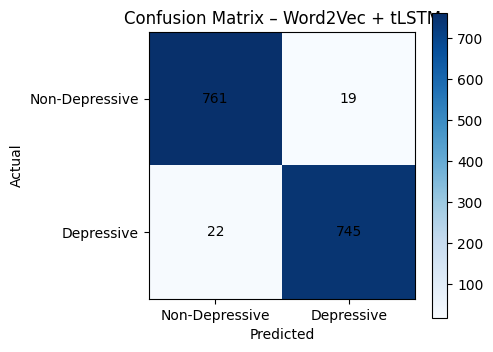

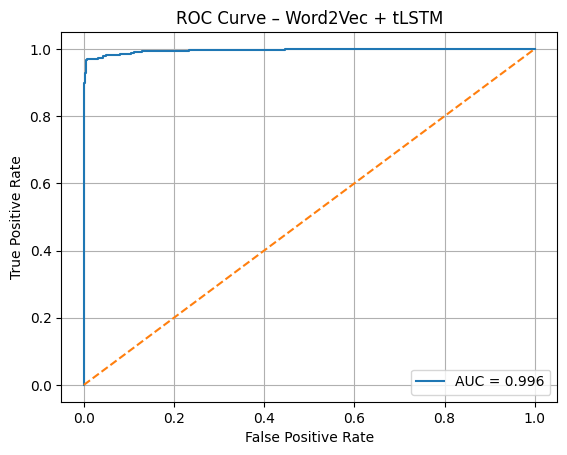

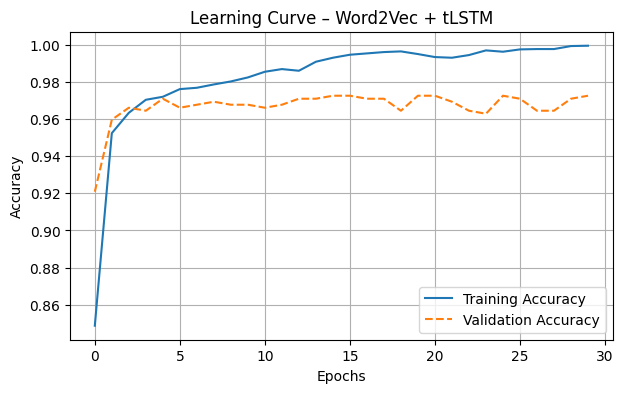

In [ ]:
# ===========================
# tLSTM with Word2Vec (Google News 300d)
# ===========================

!pip install gensim tensorflow matplotlib scikit-learn --quiet

import numpy as np
import pandas as pd
import gensim.downloader as api
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPool1D, Dense
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf

# ------------------------------
# Load Dataset
# ------------------------------
df = pd.read_csv("/content/depression_dataset_reddit_cleaned.csv").dropna(subset=["clean_text", "is_depression"])
texts = df["clean_text"].astype(str).tolist()
labels = df["is_depression"].astype(int).values

# ------------------------------
# Train-Test Split (80/20)
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.20, stratify=labels, random_state=42
)

# ------------------------------
# Tokenization
# ------------------------------
max_words = 20000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# ------------------------------
# Load Pretrained Word2Vec (Google News 300d)
# ------------------------------
print("Loading Word2Vec model (1.6GB)...")
w2v = api.load("word2vec-google-news-300")

embedding_dim = 300
embedding_matrix = np.zeros((max_words, embedding_dim))

word_index = tokenizer.word_index
for word, i in word_index.items():
    if i < max_words and word in w2v:
        embedding_matrix[i] = w2v[word]

# ------------------------------
# Build LSTM Model
# ------------------------------
model = Sequential([
    Embedding(max_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Bidirectional(LSTM(32, return_sequences=True)),
    GlobalMaxPool1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ------------------------------
# Train Model
# ------------------------------
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.10,
    epochs=30,
    batch_size=64,
    verbose=1
)

# ------------------------------
# Evaluation
# ------------------------------
y_proba = model.predict(X_test_pad).ravel()
y_pred = (y_proba > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["Non-Depressive", "Depressive"], zero_division=0)
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = auc(fpr, tpr)

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)
print(f"AUC Score: {auc_score:.4f}")

# ------------------------------
# Visualizations
# ------------------------------

# Confusion Matrix Plot
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix – Word2Vec + tLSTM")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.xticks([0,1], ["Non-Depressive", "Depressive"])
plt.yticks([0,1], ["Non-Depressive", "Depressive"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.savefig("tlstm_word2vec_confusion.png", dpi=300)
plt.show()

# ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Word2Vec + tLSTM")
plt.legend()
plt.grid()
plt.savefig("tlstm_word2vec_roc.png", dpi=300)
plt.show()

# Learning Curve
plt.figure(figsize=(7,4))
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", linestyle='--')
plt.title("Learning Curve – Word2Vec + tLSTM")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.legend(); plt.grid()
plt.savefig("tlstm_word2vec_learning.png", dpi=300)
plt.show()




---



# **SVM**


Confusion Matrix:
[[772  11]
 [ 52 712]]

AUC-ROC Curve:
AUC = 0.9859

F1-Score:
                precision    recall  f1-score   support

Non-Depressive       0.94      0.99      0.96       783
    Depressive       0.98      0.93      0.96       764

      accuracy                           0.96      1547
     macro avg       0.96      0.96      0.96      1547
  weighted avg       0.96      0.96      0.96      1547



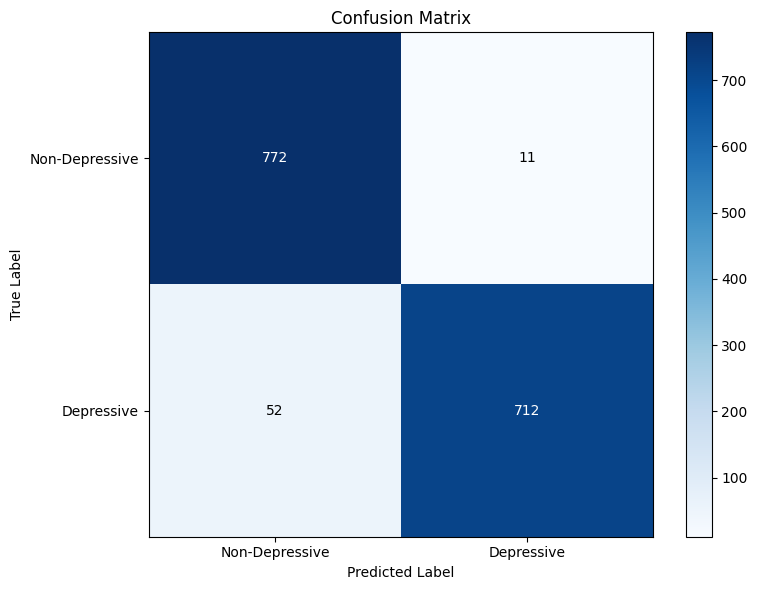

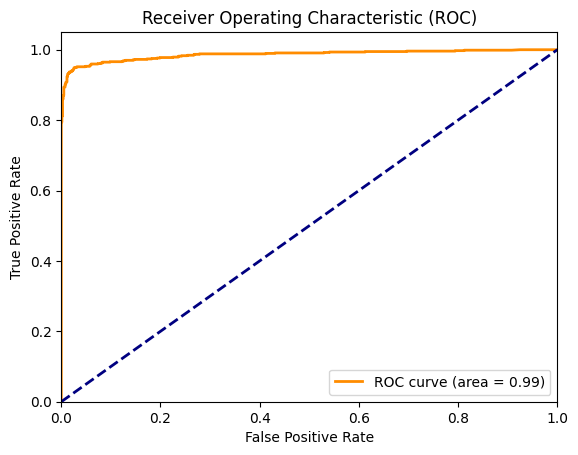

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load data from CSV file
data = pd.read_csv("/content/depression_dataset_reddit_cleaned.csv")

# Drop rows with missing or NaN labels
data = data.dropna(subset=['is_depression'])

# Drop rows with missing or NaN text
data = data.dropna(subset=['clean_text'])

texts = data["clean_text"].astype(str).tolist()
labels = data["is_depression"].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Use TfidfVectorizer to convert the texts into numerical features
vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust the number of features
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize and train the SVM model
svm_model = SVC(kernel='linear', probability=True)  # Linear kernel and probability=True for ROC curve
svm_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_tfidf)
y_pred_prob = svm_model.predict_proba(X_test_tfidf)[:, 1]  # Get the probabilities for the positive class

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
f1 = classification_report(y_test, y_pred, target_names=["Non-Depressive", "Depressive"])

# Print evaluation metrics
print("Confusion Matrix:")
print(cm)
print("\nAUC-ROC Curve:")
print(f"AUC = {roc_auc:.4f}")
print("\nF1-Score:")
print(f1)

# Save the confusion matrix as an image with annotations
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add annotations to the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

# Add labels and titles
plt.xticks([0, 1], ["Non-Depressive", "Depressive"])
plt.yticks([0, 1], ["Non-Depressive", "Depressive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('svm_confusion_matrix.png')
plt.show()

# Save the AUC-ROC curve as an image
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('svm_roc_curve.png')




---



# **RF**

Confusion Matrix:
[[779   4]
 [ 62 702]]

AUC-ROC Curve:
AUC = 0.9873

F1-Score:
                precision    recall  f1-score   support

Non-Depressive       0.93      0.99      0.96       783
    Depressive       0.99      0.92      0.96       764

      accuracy                           0.96      1547
     macro avg       0.96      0.96      0.96      1547
  weighted avg       0.96      0.96      0.96      1547



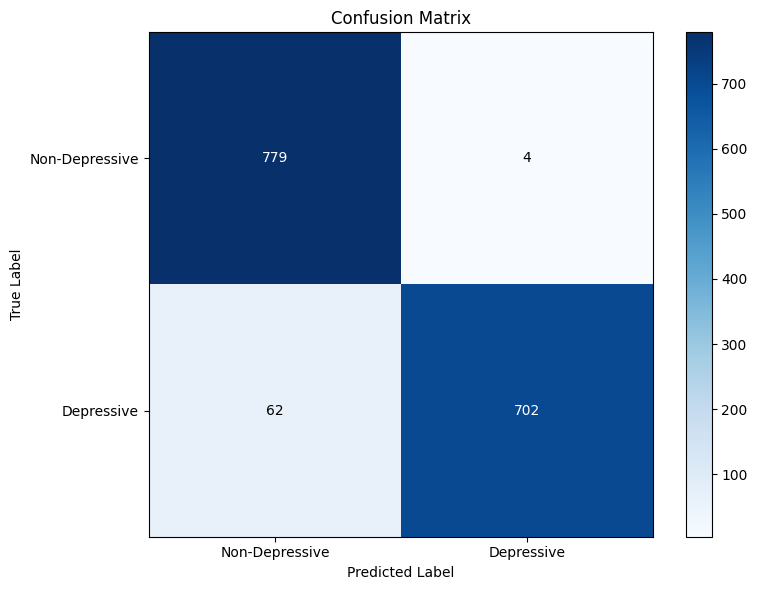

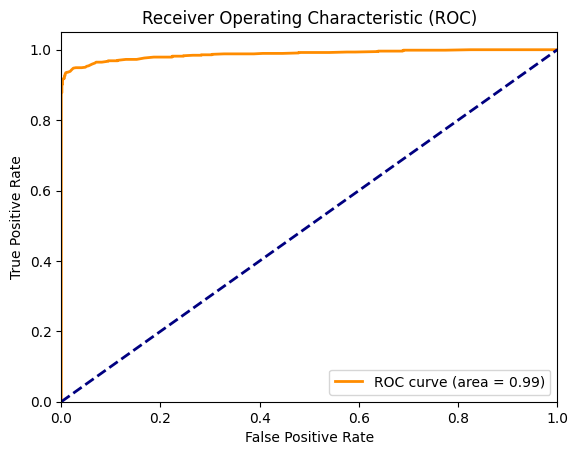

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load data from CSV file
data = pd.read_csv("/content/depression_dataset_reddit_cleaned.csv")

# Drop rows with missing or NaN labels
data = data.dropna(subset=['is_depression'])

# Drop rows with missing or NaN text
data = data.dropna(subset=['clean_text'])

texts = data["clean_text"].astype(str).tolist()
labels = data["is_depression"].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Use TfidfVectorizer to convert the texts into numerical features
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust the number of features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of trees
rf_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_tfidf)
y_pred_prob = rf_model.predict_proba(X_test_tfidf)[:, 1]  # Get the probabilities for the positive class

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
f1 = classification_report(y_test, y_pred, target_names=["Non-Depressive", "Depressive"])

# Print evaluation metrics
print("Confusion Matrix:")
print(cm)
print("\nAUC-ROC Curve:")
print(f"AUC = {roc_auc:.4f}")
print("\nF1-Score:")
print(f1)

# Save the confusion matrix as an image with annotations
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add annotations to the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

# Add labels and titles
plt.xticks([0, 1], ["Non-Depressive", "Depressive"])
plt.yticks([0, 1], ["Non-Depressive", "Depressive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('rf_confusion_matrix.png')
plt.show()

# Save the AUC-ROC curve as an image
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('rf_roc_curve.png')




---



# **1D** CNN

Hyperparameters:
Max Sequence Length: 100
Vocabulary Size: 1000
Embedding Dimension: 64
Number of Filters: 128
Kernel Size: 5
Dropout Rate: 0.5
Epochs: 30
Batch Size: 64
Validation Split: 0.2


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7586 - loss: 0.5154 - val_accuracy: 0.9386 - val_loss: 0.1695
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9618 - loss: 0.1209 - val_accuracy: 0.9450 - val_loss: 0.1715
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9787 - loss: 0.0778 - val_accuracy: 0.9466 - val_loss: 0.1695
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9847 - loss: 0.0577 - val_accuracy: 0.9402 - val_loss: 0.2197
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9875 - loss: 0.0500 - val_accuracy: 0.9345 - val_loss: 0.2648
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9903 - loss: 0.0418 - val_accuracy: 0.9426 - val_loss: 0.2367
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9938 - loss: 0.0312 - val_accuracy: 0.9499 - val_loss: 0.2407
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9937 - loss: 0.0322 - val_accuracy: 0.9515 - val_loss: 0.2605
E

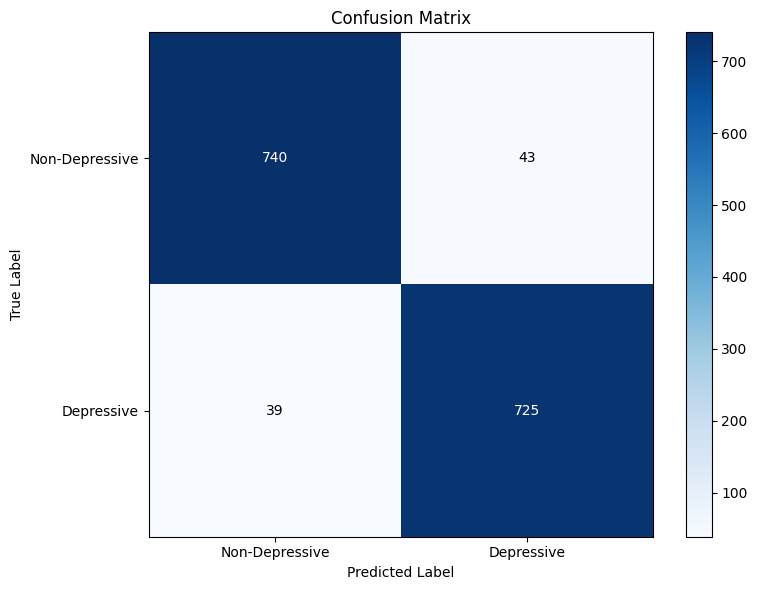

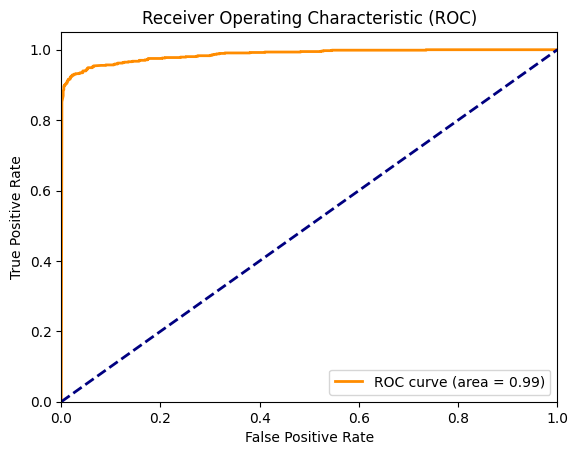

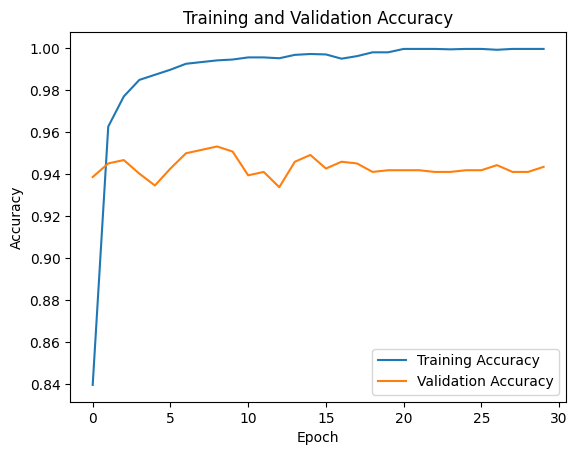

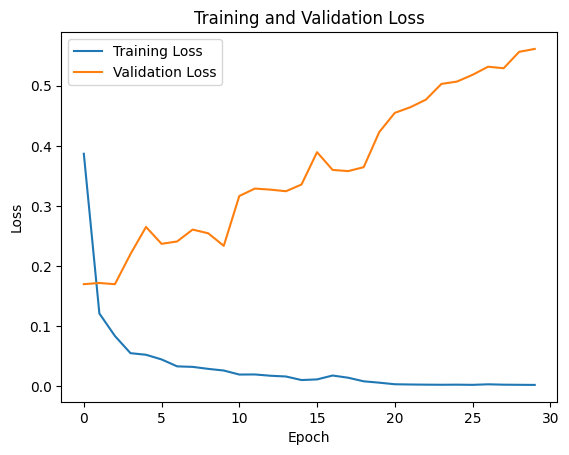

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Hyperparameters
max_sequence_length = 100  # Adjust this based on your data
num_words = 1000  # Vocabulary size
embedding_dim = 64  # Embedding dimension
num_filters = 128  # Number of filters in Conv1D layer
kernel_size = 5  # Kernel size in Conv1D layer
dropout_rate = 0.5  # Dropout rate
epochs = 30  # Number of epochs
batch_size = 64  # Batch size
validation_split = 0.2  # Validation split

# Print hyperparameters
print("Hyperparameters:")
print(f"Max Sequence Length: {max_sequence_length}")
print(f"Vocabulary Size: {num_words}")
print(f"Embedding Dimension: {embedding_dim}")
print(f"Number of Filters: {num_filters}")
print(f"Kernel Size: {kernel_size}")
print(f"Dropout Rate: {dropout_rate}")
print(f"Epochs: {epochs}")
print(f"Batch Size: {batch_size}")
print(f"Validation Split: {validation_split}")
print("\n")

# Load data from CSV file
data = pd.read_csv("/content/depression_dataset_reddit_cleaned.csv")

# Drop rows with missing or NaN labels
data = data.dropna(subset=['is_depression'])

# Drop rows with missing or NaN text
data = data.dropna(subset=['clean_text'])

texts = data["clean_text"].astype(str).tolist()
labels = data["is_depression"].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenize and pad the sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(texts)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, padding='post', maxlen=max_sequence_length)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, padding='post', maxlen=max_sequence_length)

# Define the 1D CNN model
model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_sequence_length),
    Conv1D(num_filters, kernel_size, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(num_filters, kernel_size, activation='relu'),
    MaxPooling1D(pool_size=2),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

# Evaluate the model
y_pred = model.predict(X_test_padded)

# Convert predictions to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Calculate AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Calculate F1-score
f1 = classification_report(y_test, y_pred_binary, target_names=["Non-Depressive", "Depressive"])

# Print evaluation metrics
print("Confusion Matrix:")
print(cm)
print("\nAUC-ROC Curve:")
print(f"AUC = {roc_auc:.4f}")
print("\nF1-Score:")
print(f1)

# Save the confusion matrix as an image with annotations
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add annotations to the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

# Add labels and titles
plt.xticks([0, 1], ["Non-Depressive", "Depressive"])
plt.yticks([0, 1], ["Non-Depressive", "Depressive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('cnn_confusion_matrix.png')
plt.show()

# Save the AUC-ROC curve as an image
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('cnn_roc_curve.png')

# Optionally, save the training history plot
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('cnn_training_history.png')

# Optionally, save the plot of loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('cnn_training_loss.png')


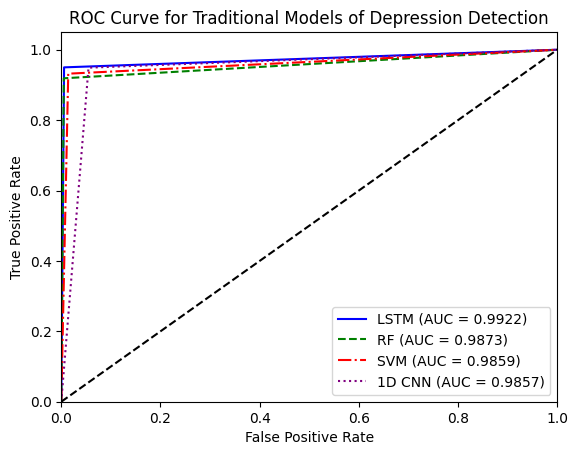

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Provided data
models = {
    "LSTM": {
        "confusion_matrix": [[3878, 22], [192, 3639]],
        "auc": 0.9922
    },
    "RF": {
        "confusion_matrix": [[779, 4], [62, 702]],
        "auc": 0.9873
    },
    "SVM": {
        "confusion_matrix": [[772, 11], [52, 712]],
        "auc": 0.9859
    },
    "1D CNN": {
        "confusion_matrix": [[740, 43], [39, 725]],
        "auc": 0.9857
    }
}

# Sort models by AUC in descending order
sorted_models = dict(sorted(models.items(), key=lambda item: item[1]["auc"], reverse=True))

# Function to calculate TPR and FPR from confusion matrix
def calculate_tpr_fpr(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix[0][0], confusion_matrix[0][1], confusion_matrix[1][0], confusion_matrix[1][1]
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr

# Plot ROC curve
plt.figure()

colors = ['blue', 'green', 'red', 'purple']
linestyles = ['-', '--', '-.', ':']

for i, (model_name, data) in enumerate(sorted_models.items()):
    tpr, fpr = calculate_tpr_fpr(data["confusion_matrix"])
    roc_auc = data["auc"]

    # Generate ROC curve points
    fpr_values, tpr_values, _ = roc_curve([0] * (data["confusion_matrix"][0][0] + data["confusion_matrix"][0][1]) + [1] * (data["confusion_matrix"][1][0] + data["confusion_matrix"][1][1]),
                                          [0] * data["confusion_matrix"][0][0] + [1] * data["confusion_matrix"][0][1] + [0] * data["confusion_matrix"][1][0] + [1] * data["confusion_matrix"][1][1])

    plt.plot(fpr_values, tpr_values, label=f'{model_name} (AUC = {roc_auc:.4f})', color=colors[i], linestyle=linestyles[i])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Traditional Models of Depression Detection')
plt.legend(loc="lower right")
plt.show()


ROC Curve for Newer Models

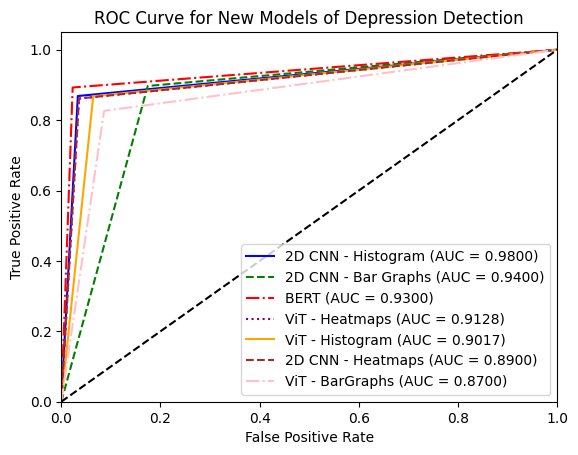

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# New models data
models = {
    "BERT": {
        "confusion_matrix": [[765, 18], [82, 682]],
        "auc": 0.9300
    },
    "2D CNN - Histogram": {
        "confusion_matrix": [[753, 26], [101, 667]],
        "auc": 0.9800
    },
    "2D CNN - Bar Graphs": {
        "confusion_matrix": [[644, 136], [79, 688]],
        "auc": 0.9400
    },
    "2D CNN - Heatmaps": {
        "confusion_matrix": [[378, 14], [53, 329]],
        "auc": 0.8900  # Assuming ROC AUC for 2D CNN - Heatmaps is calculated similarly
    },
    "ViT - Histogram": {
        "confusion_matrix": [[363, 25], [51, 335]],
        "auc": 0.9017
    },
    "ViT - BarGraphs": {
        "confusion_matrix": [[360, 34], [66, 314]],
        "auc": 0.8700
    },
    "ViT - Heatmaps": {
        "confusion_matrix": [[378, 14], [53, 329]],
        "auc": 0.9128
    }
}

# Sort models by AUC in descending order
sorted_models = dict(sorted(models.items(), key=lambda item: item[1]["auc"], reverse=True))

# Function to calculate TPR and FPR from confusion matrix
def calculate_tpr_fpr(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix[0][0], confusion_matrix[0][1], confusion_matrix[1][0], confusion_matrix[1][1]
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr

# Plot ROC curve
plt.figure()

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.']

for i, (model_name, data) in enumerate(sorted_models.items()):
    tpr, fpr = calculate_tpr_fpr(data["confusion_matrix"])
    roc_auc = data["auc"]

    # Generate ROC curve points
    fpr_values, tpr_values, _ = roc_curve([0] * (data["confusion_matrix"][0][0] + data["confusion_matrix"][0][1]) + [1] * (data["confusion_matrix"][1][0] + data["confusion_matrix"][1][1]),
                                          [0] * data["confusion_matrix"][0][0] + [1] * data["confusion_matrix"][0][1] + [0] * data["confusion_matrix"][1][0] + [1] * data["confusion_matrix"][1][1])

    plt.plot(fpr_values, tpr_values, label=f'{model_name} (AUC = {roc_auc:.4f})', color=colors[i], linestyle=linestyles[i])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for New Models of Depression Detection')
plt.legend(loc="lower right")
plt.show()

ROC Curve for Hybrid Models

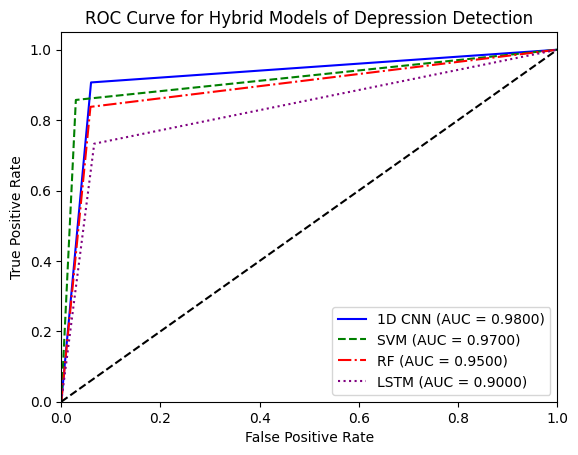

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Hybrid models data
models = {
    "LSTM": {
        "confusion_matrix": [[731, 52], [204, 560]],
        "auc": 0.9000
    },
    "RF": {
        "confusion_matrix": [[736, 46], [124, 640]],
        "auc": 0.9500
    },
    "SVM": {
        "confusion_matrix": [[760, 23], [109, 655]],
        "auc": 0.9700
    },
    "1D CNN": {
        "confusion_matrix": [[736, 47], [71, 693]],
        "auc": 0.9800
    }
}

# Sort models by AUC in descending order
sorted_models = dict(sorted(models.items(), key=lambda item: item[1]["auc"], reverse=True))

# Function to calculate TPR and FPR from confusion matrix
def calculate_tpr_fpr(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix[0][0], confusion_matrix[0][1], confusion_matrix[1][0], confusion_matrix[1][1]
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr

# Plot ROC curve
plt.figure()

colors = ['blue', 'green', 'red', 'purple']
linestyles = ['-', '--', '-.', ':']

for i, (model_name, data) in enumerate(sorted_models.items()):
    tpr, fpr = calculate_tpr_fpr(data["confusion_matrix"])
    roc_auc = data["auc"]

    # Generate ROC curve points
    fpr_values, tpr_values, _ = roc_curve([0] * (data["confusion_matrix"][0][0] + data["confusion_matrix"][0][1]) + [1] * (data["confusion_matrix"][1][0] + data["confusion_matrix"][1][1]),
                                          [0] * data["confusion_matrix"][0][0] + [1] * data["confusion_matrix"][0][1] + [0] * data["confusion_matrix"][1][0] + [1] * data["confusion_matrix"][1][1])

    plt.plot(fpr_values, tpr_values, label=f'{model_name} (AUC = {roc_auc:.4f})', color=colors[i], linestyle=linestyles[i])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Hybrid Models of Depression Detection')
plt.legend(loc="lower right")
plt.show()
